## Run this cell for all IMPORTS

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
import os 
import numpy as np
import h5py
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from joblib import dump, load
import pickle as pkl


We start by setting a base directory path that points to a data directory located one level up from the current directory. We then proceed to list and filter files from two subdirectories within this base path: one for "abnormal" data **(donnees_anorm)** and one for "normal" data **(donnees_norm)**. Specifically, we look for files with a *.h5* extension, which are HDF5 files, a common format for storing large datasets. For each of these two categories, we construct full file paths to the .h5 files and store them in separate lists. Finally, we combine these two lists into a single list, ALL_FILES, which contains the paths to all the relevant data files. We conclude by printing this combined list, effectively preparing our dataset for further analysis or processing by organizing the paths to our data files.

In [2]:
directory_path = os.path.join('new_data/')

anormal_files = os.listdir(os.path.join(directory_path, "donnees_anomalies"))
ANORMAL_FILES = [directory_path+"donnees_anomalies/"+name for name in anormal_files if ".h5" in name]

normal_files =  os.listdir(os.path.join(directory_path, "donnees_inliers"))
NORMAL_FILES = [directory_path+"donnees_inliers/"+name for name in normal_files if ".h5" in name]

ALL_FILES = NORMAL_FILES + ANORMAL_FILES 
print(f"Normal files : {len(NORMAL_FILES)}")
print(NORMAL_FILES[500])
print(f"Anormal files : {len(ANORMAL_FILES)}")
print(f"Total files : {len(ALL_FILES)}")


Normal files : 2386
new_data/donnees_inliers/Scenario_id_001468.h5
Anormal files : 200
Total files : 2586


## TODO:

- review covariance matrix removed data ✅
- corriger l'enchainement des operations de pretraitement ✅
- clean code ✅
- count NA function ✅
- save preprocessed data ✅
 

## Examine a data sample

In [3]:
# Load the data
data = pd.read_hdf('new_data/donnees_inliers/Scenario_id_001275.h5')
data.head()
data.shape

(4977, 4980)

## Keep only good features

An aeronautical engineer was hired to pinpoint the most crucial and imporant parameters all to help reduce the amount of features in our model. Our first preprocessing step will be to keep only the features most important for an aeroplane.

In [4]:

lst_features_quanti = list(pkl.load(open('VAR_QUANTI_AERO.pkl', 'rb')))
lst_features_quali = list(pkl.load(open('VAR_QUALI_AERO.pkl', 'rb')))

In [5]:
def remove_irrelevant_features(df):
    df = df[lst_features_quanti+lst_features_quali]
    return df

## (OPTIONAL) Viewing features on multiple flights

This section is for plotting data and viewing the features manually. Here we tried to see if there is any seasonality or repition in the data also if some features stand out more than the other. All this to help us clean more the database of any unecessary features.

In [ ]:
def plot_feature_across_files(file_paths, feature_name):

    plt.figure(figsize=(10, 6))
    
    for file_path in file_paths:
        data = pd.read_hdf(file_path)
        if feature_name in data.columns:
            plt.plot(data.index, data[feature_name], label=f"Feature in {file_path}")
        else:
            print(f"Feature {feature_name} not found in {file_path}")

    plt.title(f"Plot of {feature_name} across files")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
file_paths = ALL_FILES[93:100]
feature_name = "sim/cockpit/gyros/the_ind_deg4"
# feature_name = "sim/cockpit2/annunciators/hydraulic_pressure"
plot_feature_across_files(file_paths, feature_name)

In [ ]:
file_paths = ALL_FILES[101:102]
# feature_name = "sim/cockpit/gyros/the_ind_deg4"
feature_name = "sim/cockpit2/annunciators/hydraulic_pressure"
plot_feature_across_files(file_paths, feature_name)

In [ ]:
# print(os.getcwd())
weird = pd.read_hdf('new_data/donnees_inliers/Scenario_id_000110.h5')
not_weird = pd.read_hdf('new_data/donnees_inliers/Scenario_id_000117.h5')

weird["sim/cockpit2/annunciators/hydraulic_pressure"].unique(),not_weird["sim/cockpit2/annunciators/hydraulic_pressure"].unique()
# print(pd.DataFrame([weird["sim/cockpit2/annunciators/hydraulic_pressure"],not_weird["sim/cockpit2/annunciators/hydraulic_pressure"]]))

## Finding identical features across the dataset and removing them 


First thing we notices that a lot of features are the same across multiple flights. Any feature that doesn't help us distinguish anomalies is not necessary for our purpose. So we will try as a first preprocessing step to remove all the identical features across all flights

In the function below, we aggregate data from a list of **HDF5** files to identify features that are identical across all files. We start by creating a dictionary to hold all feature values from each file. As we read through each file, we collect values for each feature, extending our aggregated data. After collecting the data, we examine each feature to see if all its values are identical across the files, indicating by checking if all values for a feature reduce to a single unique value when viewed as a set. If we find any features with identical values in all files, we list them and provide a count of such features. If no features are identical across all files, we note that as well. Finally, we return the list of identical features, providing insight into the consistency of certain features across the dataset.

This function takes time to run on all files so we run only one time and save the output to *.txt* file that we then read everytime instead of re-executing the function.

In [7]:
def find_identical_features_across_files(hdf5_file_paths):
    corrupt_files = []
    data0 = pd.read_hdf(hdf5_file_paths[0])
    data0 = remove_irrelevant_features(data0)
    is_still_constant = {index: True for index in data0.columns}

    # Read data from each file
    for file_path in hdf5_file_paths[1:]:
        counter = 0
        print(f"Reading file {file_path} ...")
        try:
            data = pd.read_hdf(file_path)
        except:
            print(f"Error reading file {file_path}.")
            corrupt_files.append(file_path)
            continue
        data = remove_irrelevant_features(data)
        
        for feature in data.columns:
            if is_still_constant[feature]:
                if not(data0[feature].equals(data[feature])):
                    is_still_constant[feature] = False
                    counter += 1
                
        print(f"Number of features that are not identical: {counter}")
    
    # Identify identical features
    identical_features = [feature for feature in is_still_constant.keys() if is_still_constant[feature] == True]
    
    if identical_features:
        print(f"Identical features across all files: {identical_features}")
        print(f"Number of identical features: {len(identical_features)}")
    else:
        print("No features are identical across all files.")

    with open('common_features_norm.txt', 'w') as file:
        file.write(",".join(identical_features))

    print(f"Corrupt files: {corrupt_files}")

    return identical_features

In [22]:
const_features = find_identical_features_across_files(NORMAL_FILES[56:70])
"""
with open("common_features_norm.txt") as f_ : 
    string_features = f_.read()
    const_features = string_features[1:][:-1].replace(" ","").replace("'","").split(",")
"""
print(const_features)
print(len(const_features))

Reading file new_data/donnees_inliers/Scenario_id_000982.h5 ...
Number of features that are not identical: 315
Reading file new_data/donnees_inliers/Scenario_id_000983.h5 ...
Number of features that are not identical: 364
Reading file new_data/donnees_inliers/Scenario_id_000984.h5 ...
Number of features that are not identical: 0
Reading file new_data/donnees_inliers/Scenario_id_000986.h5 ...
Number of features that are not identical: 0
Reading file new_data/donnees_inliers/Scenario_id_000987.h5 ...
Number of features that are not identical: 0
Reading file new_data/donnees_inliers/Scenario_id_000989.h5 ...
Number of features that are not identical: 0
Reading file new_data/donnees_inliers/Scenario_id_000990.h5 ...
Number of features that are not identical: 0
Reading file new_data/donnees_inliers/Scenario_id_000991.h5 ...
Number of features that are not identical: 0
Reading file new_data/donnees_inliers/Scenario_id_000992.h5 ...
Number of features that are not identical: 0
Reading file ne

In [9]:
def remove_useless_features(data):
    unique_data = data.loc[:, ~data.columns.isin(const_features)]
    if 'sim/time/total_running_time_sec' in unique_data.columns:
        del unique_data['sim/time/total_running_time_sec']
    if 'sim/time/total_flight_time_sec' in unique_data.columns:
        del unique_data['sim/time/total_flight_time_sec']
    return unique_data

# Handling Missing values (NaN)

Another very important step in preprocessing is to remove or fill in missing features. In this section we will try to count these missing parameters across features and flights. we will afterwards try filling them if neccessary.

In [10]:
def count_nan_values_in_dataframe(data):
    sum = 0
    for feature in data.columns:
        nan_count = data[feature].isna().sum()
        if nan_count > 0:
            print(f"Feature {feature} has {nan_count} NaN values")
            sum += nan_count
    print(f"Total NaN values: {sum}")

def count_nan_values_in_file(hdf5_file_path):
    data = pd.read_hdf(hdf5_file_path)
    count_nan_values_in_dataframe(data)

# Unit tests

In [45]:
# Unit tests
test_frame = pd.DataFrame([[1,2,3],[4,None,6],[7,8,None]], columns=["A","B","C"])
count_nan_values_in_dataframe(test_frame)
print("")
test_frame2 = pd.DataFrame([[0,0,None],[0,0,0],[0,0,0]], columns=["A","B","C"])
count_nan_values_in_dataframe(test_frame)


Feature B has 1 NaN values
Feature C has 1 NaN values
Total NaN values: 2


Counting the Nan values on all files

In [11]:
# Count NaN values in all files
for file_ in ALL_FILES:
    count_nan_values_in_file(file_)
    print("")

Total NaN values: 0

Total NaN values: 0

Total NaN values: 0

Total NaN values: 0

Total NaN values: 0

Total NaN values: 0

Total NaN values: 0

Total NaN values: 0



KeyboardInterrupt: 

In the cell below we try to plot each feature and the corresponding number of Nan values. We concluded that there are no missing values in our database 👌

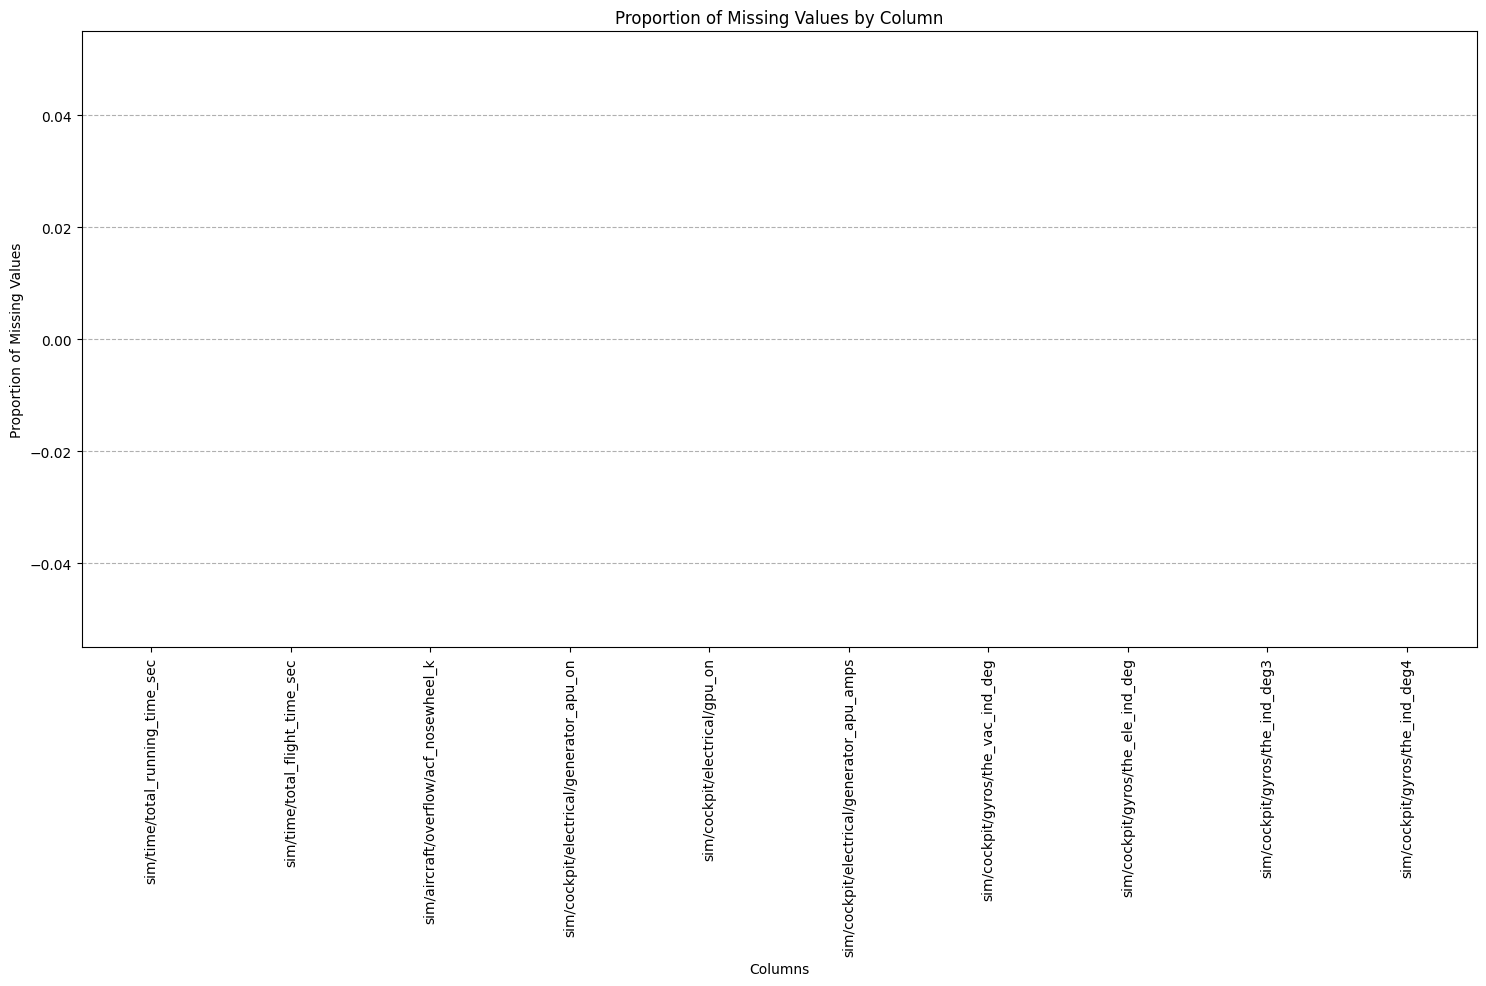

In [47]:
ft = 10 # number of features to consider (considering many features will lead to an unreadable plot)

test = pd.read_hdf(ALL_FILES[0])
test = test.iloc[:, :ft]
missing_ratio = test.isnull().sum() / len(test)

# Plotting
plt.figure(figsize=(18, 8))  # Set the figure size
missing_ratio.plot.bar(colormap='Paired')  # Create a bar plot with a specified colormap
plt.title('Proportion of Missing Values by Column')  # Add a title to the plot
plt.xlabel('Columns')  # Add an x-label
plt.ylabel('Proportion of Missing Values')  # Add a y-label
# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--')  # Add horizontal grid lines for easier evaluation
plt.show()  # Display the plot

## Downsampling the DataFrames

With the coerce_data function, we efficiently downsample our DataFrame by selecting every nth row, keeping all columns. This approach helps us in preprocessing by reducing the dataset size, which in turn, decreases memory usage and computational time. It's particularly beneficial for handling large datasets, speeding up exploratory analysis, or when we want to simplify time-series data to focus on broader trends.

In [13]:
# Coarse Data (divide data by n)
def coerce_data(data, n):
    return data.iloc[::n, :]

In [6]:
def dowsnsample(df, n):
    N = df.shape[0]
    sample = N//n + 1
    return df.iloc[::sample, :]

In the cell below we will try visualising a datapoint before and after the downsampling for comparasion purposes

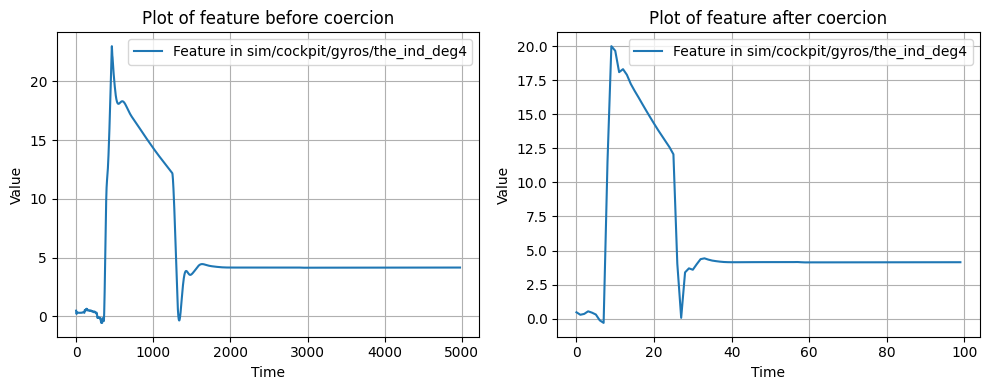

In [11]:
test = pd.read_hdf(ALL_FILES[0])
feature_name0 = "sim/cockpit/gyros/the_ind_deg4"
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4)) # 1 row, 2 columns
# Plotting the original data
ax1.plot(test.index, test[feature_name0], label=f"Feature in {feature_name0}")
ax1.set_title(f"Plot of feature before coercion")
ax1.set_xlabel("Time")
ax1.set_ylabel("Value")
ax1.legend()
ax1.grid(True)
# Plotting the coerced data
coerced_data = coerce_data(test, 50)
coerced_data = coerced_data.reset_index(drop=True)
ax2.plot(coerced_data.index, coerced_data[feature_name0], label=f"Feature in {feature_name0}")
ax2.set_title(f"Plot of feature after coercion")
ax2.set_xlabel("Time")
ax2.set_ylabel("Value")
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.show()

We can see that we don't really lose so much data. We can safely downsample the data 10 times for faster computing 😎

## Removing highly correlated features


In this section, we calculate the correlation matrix coefficient for all pairs of features in the given DataFrame to identify how closely related they are. We then focus on finding features that are almost perfectly correlated , implying redundancy. We ensure our dataset retains only distinct, uncorrelated parameters for more effective analysis or modeling.


```python
def remove_correlated_parameter(df):
    df_corr = df.corr(method='pearson')
    df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > 0.9999).any()
    un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
    print('Uncorrelate parameters:', len(un_corr_idx)) 
    # Find parameters to remove
    param_to_remove = set(df.columns) - set(un_corr_idx)
    print('Parameters to remove:', param_to_remove)
    #index_to_remove = [df.columns.index(p) for p in param_to_remove]
    # remove parameters from dataframe
    df_result = df.drop(columns=param_to_remove)
    return df_result
```

## Computing intersection of all uncorrelated features

For our purpose it is not as simple as calculating the correlating matrix for one flight. We need to calculate the correlation coeffefficients for all flights and then calculate the intersection of the uncorrelated features se that we can safely remove then from all flights

TODO:

- rewrite the test section below
- Yes, it is intersection and not union
- keep only one function to remove correlated variables the same way i did in the constant features part


In [9]:
def find_correlated_parameter_across_files():
    
    def remove_correlated_parameter(df):
        df_corr = df.corr(method='pearson')
        df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > 0.98).any()
        un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
        #print('Uncorrelate parameters:', len(un_corr_idx)) 
        # Find parameters to remove
        param_to_remove = set(df.columns) - set(un_corr_idx)
        #print('Parameters to remove:', param_to_remove)
        #index_to_remove = [df.columns.index(p) for p in param_to_remove]
        # remove parameters from dataframe
        df_result = df.drop(columns=param_to_remove)
        return df_result,param_to_remove
    """

    def remove_correlated_parameter(df):
        # Calculate the correlation matrix
        df_corr = df.corr(method='pearson')
        
        # Create a mask for the upper triangle of the correlation matrix
        upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(bool))
        
        # Find columns with a correlation greater than the threshold
        to_drop = [column for column in upper.columns if any(upper[column] > 0.9999)]
        
        # However, we want to keep one representative for each set of correlated features
        # Identify the unique sets of correlated features (this may not be perfect for complex cases)
        correlated_groups = {}
        for column in to_drop:
            correlated = [col for col in upper.columns if upper[col][column] > 0.9999]
            if correlated:
                # Sort to ensure consistency
                sorted_correlated = sorted(correlated)
                # Use the first item as the key representative
                key_representative = sorted_correlated[0]
                if key_representative not in correlated_groups:
                    correlated_groups[key_representative] = set()
                correlated_groups[key_representative].update(sorted_correlated)
        
        # Flatten the groups to get a list of columns to drop, except the representatives
        representatives = set(correlated_groups.keys())
        all_correlated = set([item for sublist in correlated_groups.values() for item in sublist])
        final_to_drop = all_correlated - representatives
        
        # Remove the columns
        df_result = df.drop(columns=list(final_to_drop))
        
        print('Kept as representatives:', representatives)
        print('Parameters to remove:', final_to_drop)
        
        return df_result, final_to_drop
    """
    
    data = pd.read_hdf(NORMAL_FILES[0])
    print(f"file : {NORMAL_FILES[0]} ...")
    unique_data = remove_irrelevant_features(data)
    unique_data.fillna(method='ffill')
    unique_data = dowsnsample(unique_data, 100)
    unique_data, removed = remove_correlated_parameter(unique_data)
    inter = set(removed)


    for file_ in NORMAL_FILES[1:545]+ANORMAL_FILES:
        data = pd.read_hdf(file_)
        print(f"file : {file_} ...")
        unique_data = remove_irrelevant_features(data)
        unique_data.fillna(method='ffill')
        unique_data = dowsnsample(unique_data, 100)
        unique_data, removed = remove_correlated_parameter(unique_data)
        #print(len(removed))

        if (len(inter) == 0):
            print("inter is empty")
            return set()
        else:
            inter = inter.intersection(removed)
            print(f"len(inter) : {len(inter)}")

    with open("must_remove_soufyane_0.98.txt", "a") as f_ : 
        f_.write(str(inter))
        
    print(inter)
    return inter

find_correlated_parameter_across_files()

file : new_data/donnees_inliers/Scenario_id_000917.h5 ...
file : new_data/donnees_inliers/Scenario_id_000918.h5 ...
len(inter) : 226
file : new_data/donnees_inliers/Scenario_id_000919.h5 ...
len(inter) : 224
file : new_data/donnees_inliers/Scenario_id_000920.h5 ...
len(inter) : 223
file : new_data/donnees_inliers/Scenario_id_000921.h5 ...
len(inter) : 222
file : new_data/donnees_inliers/Scenario_id_000922.h5 ...
len(inter) : 222
file : new_data/donnees_inliers/Scenario_id_000924.h5 ...
len(inter) : 220
file : new_data/donnees_inliers/Scenario_id_000925.h5 ...
len(inter) : 220
file : new_data/donnees_inliers/Scenario_id_000926.h5 ...
len(inter) : 219
file : new_data/donnees_inliers/Scenario_id_000927.h5 ...
len(inter) : 219
file : new_data/donnees_inliers/Scenario_id_000928.h5 ...
len(inter) : 219
file : new_data/donnees_inliers/Scenario_id_000929.h5 ...
len(inter) : 219
file : new_data/donnees_inliers/Scenario_id_000930.h5 ...
len(inter) : 219
file : new_data/donnees_inliers/Scenario_i

{'sim/cockpit/autopilot/airspeed_mode',
 'sim/cockpit/autopilot/altitude',
 'sim/cockpit/autopilot/autopilot_mode',
 'sim/cockpit/autopilot/autopilot_state',
 'sim/cockpit/autopilot/current_altitude',
 'sim/cockpit/autopilot/flight_director_pitch',
 'sim/cockpit/autopilot/flight_director_roll',
 'sim/cockpit/autopilot/heading',
 'sim/cockpit/autopilot/heading_mag',
 'sim/cockpit/autopilot/heading_mode',
 'sim/cockpit/autopilot/syn_hold_deg',
 'sim/cockpit/autopilot/vertical_velocity',
 'sim/cockpit/gyros/phi_ind_ahars_copilot_deg',
 'sim/cockpit/gyros/phi_ind_ahars_pilot_deg',
 'sim/cockpit/gyros/phi_ind_deg4',
 'sim/cockpit/gyros/phi_ind_elec_copilot_deg',
 'sim/cockpit/gyros/phi_ind_elec_pilot_deg',
 'sim/cockpit/gyros/phi_ind_vac_copilot_deg',
 'sim/cockpit/gyros/phi_ind_vac_pilot_deg',
 'sim/cockpit/gyros/psi_ind_ahars_copilot_degm',
 'sim/cockpit/gyros/psi_ind_degm4',
 'sim/cockpit/gyros/psi_ind_elec_copilot_degm',
 'sim/cockpit/gyros/psi_ind_elec_pilot_degm',
 'sim/cockpit/gyros/

We then proceed in the same way that we did with the constant features: We save the output of the function in a file and then read the file instead of re-calling the function each time 

In [10]:
corr_features = []
with open("must_remove_soufyane_0.98.txt") as f_ : 
    string_features = f_.read()
    corr_features = string_features[1:][:-1].replace(" ","").replace("'","").split(",")

print(corr_features)    
print(len(corr_features))

['sim/cockpit/autopilot/flight_director_pitch', 'sim/cockpit2/autopilot/autopilot_on', 'sim/flightmodel/controls/wing2l_elv1def', 'sim/flightmodel/controls/wing3r_ail1def', 'sim/cockpit/gyros/phi_ind_elec_pilot_deg', 'sim/flightmodel/controls/mwing03_rud1def', 'sim/cockpit2/autopilot/altitude_hold_ft', 'sim/cockpit/autopilot/current_altitude', 'sim/cockpit2/gauges/indicators/calibrated_airspeed_kts_copilot', 'sim/flightmodel/controls/mwing08_ail2def', 'sim/cockpit/gyros/the_ind_vac_copilot_deg', 'sim/flightmodel/controls/wing4r_ail1def', 'sim/cockpit2/autopilot/roll_status', 'sim/cockpit/gyros/the_ind_vac_pilot_deg', 'sim/cockpit2/gauges/indicators/radio_altimeter_height_ft_copilot', 'sim/flightmodel/controls/wing4r_fla2def', 'sim/flightmodel/controls/mwing08_elv1def', 'sim/cockpit2/autopilot/heading_status', 'sim/cockpit/gyros/the_ind_elec_copilot_deg', 'sim/cockpit/gyros/phi_ind_vac_pilot_deg', 'sim/cockpit2/autopilot/altitude_dial_ft', 'sim/flightmodel/controls/wing2l_ail2def', 'sim

In [11]:
def remove_correlated_parameters(df):
    df_result = df.drop(columns=corr_features, errors='ignore')
    return df_result

## Normalization and Standarization

For the purpose of our studies we will be using standard MinMax scaling to normalize our time series. We want though to fit our scaler on all normal data so that it takes the global min and max values. Afterwards we will be able to transform all the necessary data freely with the aforementioned scaler.

In [15]:
df_ = pd.read_hdf(NORMAL_FILES[0])
df_ = remove_irrelevant_features(df_)
df_ = remove_correlated_parameters(df_)
df_ = dowsnsample(df_, 100)
print(df_.shape)

scalar = pd.DataFrame(index=['max', 'min'], columns=df_.columns).astype(np.float64)
def minmax(df_, scalar):
    for col in df_.columns:
        scalar.at['max', col] = max(scalar.at['max', col], df_[col].max()) if pd.notna(scalar.at['max', col]) else df_[col].max()
        scalar.at['min', col] = min(scalar.at['min', col], df_[col].min()) if pd.notna(scalar.at['min', col]) else df_[col].min()
    return scalar

for i, file_ in enumerate(NORMAL_FILES[1:]):
    try:
        data = pd.read_hdf(file_)
    except:
        print(f"Error reading file {file_}.")
        continue
    data = remove_irrelevant_features(data)
    data = remove_correlated_parameters(data)
    data = dowsnsample(data, 100)
    scalar = minmax(data, scalar)
    print(f"{100*(i+1)/len(NORMAL_FILES):.4f}", "%", end="\r")





(100, 507)


In [23]:
scalar.head()

,sim/cockpit/electrical/generator_apu_amps,sim/cockpit/gyros/the_vac_ind_deg,sim/cockpit/gyros/the_ind_deg3,sim/cockpit/gyros/psi_vac_ind_degm,sim/cockpit/gyros/psi_ele_ind_degm,sim/cockpit/gyros/psi_ind_degm3,sim/cockpit/gyros/psi_ind_ahars_pilot_degm,sim/cockpit/gyros/phi_vac_ind_deg,sim/cockpit/gyros/phi_ele_ind_deg,sim/cockpit/gyros/phi_ind_deg3,...,sim/cockpit/warnings/annunciators/autopilot,sim/cockpit/warnings/annunciators/hydraulic_pressure,sim/cockpit2/annunciators/autopilot,sim/cockpit2/annunciators/autopilot_disconnect,sim/cockpit2/annunciators/autopilot_trim_fail,sim/cockpit2/annunciators/hydraulic_pressure,sim/cockpit2/autopilot/autopilot2_avail,sim/cockpit2/autopilot/master_flight_director,sim/cockpit2/controls/gear_handle_down,sim/cockpit2/switches/electric_hydraulic_pump_on
max,0.0,60.141136,84.912071,359.991638,359.991577,359.998718,359.993835,104.899673,104.899673,56.178055,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
min,0.0,-60.222824,-68.595901,0.003784,0.004699,0.003302,0.000000,-110.038940,-110.038940,-179.131607,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
def normalizer(df_, scalar):
    for col in df_.columns:
        min_val = scalar.at['min', col]
        max_val = scalar.at['max', col]
        
        if max_val - min_val != 0:
            df_[col] = (df_[col] - min_val) / (max_val - min_val)
        else:
            df_[col] = 0
            
    return df_

## Save the scaler

In [19]:
with open('scalar_qwada.pkl', 'wb') as file:
    # Serialize and save the object
    pkl.dump(scalar, file)

## Load The Scaler

In [21]:
with open('scalar_qwada.pkl', 'rb') as file:
    # Deserialize and load the object
    scalar = pkl.load(file)
scalar.shape

(2, 507)

## TEST THE SCALER

In [24]:
test = pd.read_hdf(ALL_FILES[0])
test = remove_irrelevant_features(test)
test = remove_correlated_parameters(test)
test = dowsnsample(test, 100)
# scaler transform test
scaled_test = normalizer(test.copy(), scalar)
test.head()
scaled_test.head()


,sim/cockpit/electrical/generator_apu_amps,sim/cockpit/gyros/the_vac_ind_deg,sim/cockpit/gyros/the_ind_deg3,sim/cockpit/gyros/psi_vac_ind_degm,sim/cockpit/gyros/psi_ele_ind_degm,sim/cockpit/gyros/psi_ind_degm3,sim/cockpit/gyros/psi_ind_ahars_pilot_degm,sim/cockpit/gyros/phi_vac_ind_deg,sim/cockpit/gyros/phi_ele_ind_deg,sim/cockpit/gyros/phi_ind_deg3,...,sim/cockpit/warnings/annunciators/autopilot,sim/cockpit/warnings/annunciators/hydraulic_pressure,sim/cockpit2/annunciators/autopilot,sim/cockpit2/annunciators/autopilot_disconnect,sim/cockpit2/annunciators/autopilot_trim_fail,sim/cockpit2/annunciators/hydraulic_pressure,sim/cockpit2/autopilot/autopilot2_avail,sim/cockpit2/autopilot/master_flight_director,sim/cockpit2/controls/gear_handle_down,sim/cockpit2/switches/electric_hydraulic_pump_on
0,0,0.501474,0.447745,0.393761,0.393764,0.393732,0.393749,0.510722,0.510722,0.760132,...,0.0,0.0,0.0,1.0,0,0.0,0.0,0,1.0,0.0
50,0,0.502786,0.448774,0.393772,0.393778,0.393742,0.393753,0.511624,0.511624,0.760957,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0,1.0,0.0
100,0,0.503401,0.449256,0.393774,0.393782,0.393736,0.393747,0.511686,0.511686,0.761013,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0,1.0,0.0
150,0,0.504903,0.450434,0.394754,0.394764,0.394710,0.394723,0.511023,0.511023,0.760407,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0,1.0,0.0
200,0,0.504527,0.450139,0.399948,0.399961,0.399915,0.399933,0.509440,0.509440,0.758962,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0,1.0,0.0


In [26]:
# function that run the normalization on all files in NORMAL_FILES and see if there is a value that is not between 0 and 1
def check_normalisation(scalar, dir_):
    for i,file in enumerate(dir_): 
        data = pd.read_hdf(file)
        data = remove_irrelevant_features(data)
        data = remove_correlated_parameters(data)
        data = dowsnsample(data, 100)
        scaled_data = normalizer(data, scalar)
        if ((scaled_data.max().max()-0.000000001) > 1 or (scaled_data.min().min()+0.000000001) < 0):
            print(f"Error in file {file} min : {scaled_data.min().min()} max : {scaled_data.max().max()}")
            return False
        print(f"{100*i/len(dir_):.4f}", "%", end="\r") 
    return True

check_normalisation(scalar, NORMAL_FILES)

True

The scaler is trained on the data with no features removed and so it is necessary when trying to use it to do so before removing the constant or the coreelated features.

## Preprocessing the Dataframes

it the cell below we apply all the mentioned methods on our database. We then save the new files for our model.

In [27]:
## Doing all of the above for all files
## This will take a while
#data_list = []
i = 0
for file_path in ALL_FILES:
    i += 1
    d = pd.read_hdf(file_path)
    d = remove_irrelevant_features(d)
    d = remove_correlated_parameters(d)
    d = dowsnsample(d, 100)
    d = normalizer(d, scalar)
    d = d.reset_index(drop=True)
    d = d.fillna(method='ffill')
    name = file_path.split("/")
    name[1] = name[1] + "_proc"
    d.to_hdf("/".join(name), key='data', mode='w')
    print(f"{100*i/len(ALL_FILES):.4f}", "%", end="\r") 

    #data_list.append(d)

### Testing the new saved files

In [28]:
name = ALL_FILES[1].split("/")
name[1] = name[1] + "_proc"
test = pd.read_hdf("/".join(name))
print(name)
print(f"the sample size is {test.shape}")
print(f"here are the columns {test.columns}")
test.head()

['new_data', 'donnees_inliers_proc', 'Scenario_id_000918.h5']
the sample size is (100, 507)
here are the columns Index(['sim/cockpit/electrical/generator_apu_amps',
       'sim/cockpit/gyros/the_vac_ind_deg', 'sim/cockpit/gyros/the_ind_deg3',
       'sim/cockpit/gyros/psi_vac_ind_degm',
       'sim/cockpit/gyros/psi_ele_ind_degm', 'sim/cockpit/gyros/psi_ind_degm3',
       'sim/cockpit/gyros/psi_ind_ahars_pilot_degm',
       'sim/cockpit/gyros/phi_vac_ind_deg',
       'sim/cockpit/gyros/phi_ele_ind_deg', 'sim/cockpit/gyros/phi_ind_deg3',
       ...
       'sim/cockpit/warnings/annunciators/autopilot',
       'sim/cockpit/warnings/annunciators/hydraulic_pressure',
       'sim/cockpit2/annunciators/autopilot',
       'sim/cockpit2/annunciators/autopilot_disconnect',
       'sim/cockpit2/annunciators/autopilot_trim_fail',
       'sim/cockpit2/annunciators/hydraulic_pressure',
       'sim/cockpit2/autopilot/autopilot2_avail',
       'sim/cockpit2/autopilot/master_flight_director',
       's

,sim/cockpit/electrical/generator_apu_amps,sim/cockpit/gyros/the_vac_ind_deg,sim/cockpit/gyros/the_ind_deg3,sim/cockpit/gyros/psi_vac_ind_degm,sim/cockpit/gyros/psi_ele_ind_degm,sim/cockpit/gyros/psi_ind_degm3,sim/cockpit/gyros/psi_ind_ahars_pilot_degm,sim/cockpit/gyros/phi_vac_ind_deg,sim/cockpit/gyros/phi_ele_ind_deg,sim/cockpit/gyros/phi_ind_deg3,...,sim/cockpit/warnings/annunciators/autopilot,sim/cockpit/warnings/annunciators/hydraulic_pressure,sim/cockpit2/annunciators/autopilot,sim/cockpit2/annunciators/autopilot_disconnect,sim/cockpit2/annunciators/autopilot_trim_fail,sim/cockpit2/annunciators/hydraulic_pressure,sim/cockpit2/autopilot/autopilot2_avail,sim/cockpit2/autopilot/master_flight_director,sim/cockpit2/controls/gear_handle_down,sim/cockpit2/switches/electric_hydraulic_pump_on
0,0,0.504271,0.449938,0.395734,0.395687,0.395609,0.395675,0.513104,0.513104,0.762308,...,0.0,0.0,0.0,1.0,0,0.0,0.0,0,1.0,0.0
1,0,0.502779,0.448769,0.395760,0.395689,0.395651,0.395669,0.512183,0.512183,0.761467,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0,1.0,0.0
2,0,0.503432,0.449281,0.395778,0.395685,0.395638,0.395656,0.512215,0.512215,0.761497,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0,1.0,0.0
3,0,0.505046,0.450546,0.396098,0.395982,0.395928,0.395946,0.510931,0.510931,0.760324,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0,1.0,0.0
4,0,0.504131,0.449829,0.397855,0.397716,0.397660,0.397679,0.510473,0.510473,0.759905,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0,1.0,0.0


# LSTM autoencoder Test Model

In [3]:
import os
import pandas as pd
import numpy as np

In [4]:


directory_path = os.path.join('new_data/')

anormal_files = os.listdir(os.path.join(directory_path, "donnees_anomalies_proc"))
ANORMAL_FILES_PROC = [directory_path+"donnees_anomalies_proc/"+name for name in anormal_files if ".h5" in name]

normal_files =  os.listdir(os.path.join(directory_path, "donnees_inliers_proc"))
NORMAL_FILES_PROC = [directory_path+"donnees_inliers_proc/"+name for name in normal_files if ".h5" in name]

ALL_FILES_PROC = NORMAL_FILES_PROC + ANORMAL_FILES_PROC 
print(f"Normal files_PROC : {len(NORMAL_FILES_PROC)}")
print(f"Anormal files_PROC : {len(ANORMAL_FILES_PROC)}")
print(f"Total files_PROC : {len(ALL_FILES_PROC)}")


Normal files_PROC : 2386
Anormal files_PROC : 200
Total files_PROC : 2586


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Input, Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from keras import regularizers



After preprocessing, We should convert the data into [samples, timesteps, features] format that we'll then use as input for your autoencoder.

In [7]:

train_data = []
for file in NORMAL_FILES_PROC:
    data = pd.read_hdf(file)

    train_data.append(data.to_numpy())

train_data = np.array(train_data)
print(train_data.shape)


(2386, 100, 507)


## Preparing Data for the model

In [54]:
"""
def autoencoder_model(X):
    model = Sequential()
    model.add(LSTM(1024, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
    model.add(LSTM(512, return_sequences=False))
    model.add(Dropout(rate=0.2))

    model.add(RepeatVector(X.shape[1]))

    model.add(LSTM(512, return_sequences=True))
    model.add(LSTM(1024, return_sequences=True))
    model.add(Dropout(rate=0.2))
    model.add(TimeDistributed(Dense(X.shape[2])))
    model.compile(optimizer='adam', loss='mae')
    return model
"""
"""
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(64, activation='tanh', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00), dropout=0.2)(inputs)
    L2 = LSTM(16, activation='tanh', return_sequences=False, dropout=0.2)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(16, activation='tanh', return_sequences=True, dropout=0.2)(L3)
    L5 = LSTM(64, activation='tanh', return_sequences=True, dropout=0.2)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model
"""
"""
def autoencoder_model(X): # , latent_dim=10, timesteps=40):
    # Input
    inputs = Input(shape=(X.shape[1], X.shape[2]))

    # Encoder
    encoded = LSTM(40, return_sequences=True, dropout=0.2)(inputs)
    encoded = LSTM(8, return_sequences=False, dropout=0.2)(encoded)

    # Repeat vector
    repeated_vector = RepeatVector(X.shape[1])(encoded)

    # Decoder
    decoded = LSTM(40, return_sequences=True, dropout=0.1)(repeated_vector)
    decoded = LSTM(X.shape[2], return_sequences=True, dropout=0.1)(decoded)
    decoded = TimeDistributed(Dense(X.shape[2]))(decoded)  # Match the original feature dimension
    # Model
    model = Model(inputs, decoded)

    return model
"""
def autoencoder_model(X):
    visible = Input(shape=(X.shape[1],X.shape[2]))
    encoder = LSTM(512, activation='relu')(visible)

    #Decoder 1 for prediction
    decoder1 = RepeatVector(X.shape[1])(encoder)
    decoder1 = LSTM(512, activation='relu', return_sequences=True)(decoder1)
    decoder1 = TimeDistributed(Dense(1))(decoder1)

    #Decoder 2 for prediction
    decoder2 = RepeatVector(X.shape[2])(encoder)
    decoder2 = LSTM(512, activation='relu', return_sequences=True)(decoder2)
    decoder2 = TimeDistributed(Dense(1))(decoder2)

    #tie up the encoder and the decoders
    model = Model(inputs=visible, outputs=[decoder1, decoder2])

    return model
    
    
model = autoencoder_model(train_data)

model.compile(optimizer='adam', loss='mae')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 498, 270)]           0         []                            
                                                                                                  
 lstm_35 (LSTM)              (None, 512)                  1603584   ['input_6[0][0]']             
                                                                                                  
 repeat_vector_13 (RepeatVe  (None, 498, 512)             0         ['lstm_35[0][0]']             
 ctor)                                                                                            
                                                                                                  
 repeat_vector_14 (RepeatVe  (None, 270, 512)             0         ['lstm_35[0][0]']       

In [55]:
# fit the model to the data
nb_epochs = 10
batch_size = 8
history = model.fit(train_data, train_data, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.1, callbacks=[early_stopping]).history

Epoch 1/10


ValueError: in user code:

    File "c:\Users\playi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\playi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\playi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\playi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\playi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "c:\Users\playi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\playi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\playi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\playi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\losses.py", line 1848, in mean_absolute_error
        return backend.mean(tf.abs(y_pred - y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 270 and 498 for '{{node mean_absolute_error_1/sub}} = Sub[T=DT_FLOAT](model_5/time_distributed_14/Reshape_1, IteratorGetNext:1)' with input shapes: [?,270,1], [?,498,270].


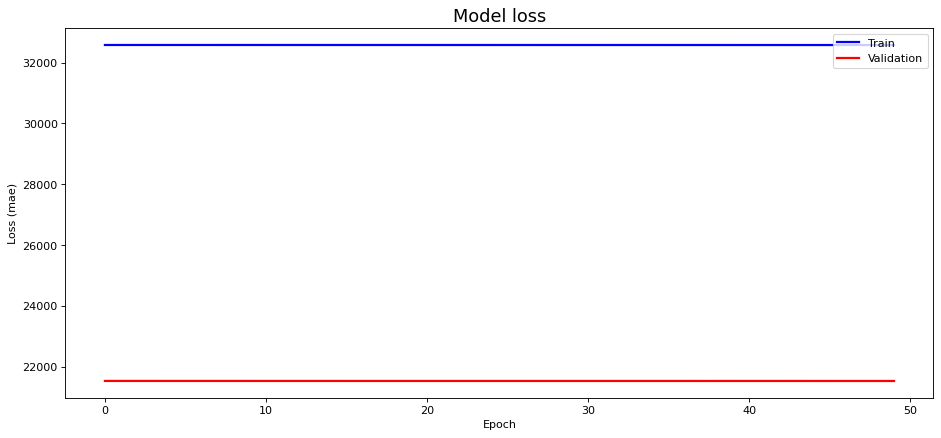

In [65]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [66]:
test_d = pd.read_hdf(NORMAL_FILES_PROC[1])
test_d = test_d.to_numpy()
print(test_d.shape)
new_data_point = test_d.reshape(1, test_d.shape[0], test_d.shape[1])
print(new_data_point.shape)
prediction = model.predict(new_data_point)
print(f"the shape of the prediction is: {prediction.shape}")
print(prediction)
mae = mean_squared_error(test_d.flatten(), prediction.flatten())
print("Mean Absolute Error:", mae)

(498, 270)
(1, 498, 270)
1/1 [==============================] - 1s 540ms/step
the shape of the prediction is: (1, 498, 270)
[[[ 0.18568946  0.18375362  0.36109343 ...  0.03031202  0.37149367
   -0.00943073]
  [ 0.24968831  0.24641639  0.65389955 ...  0.03907304  0.58163023
   -0.01606757]
  [ 0.2816373   0.2776895   0.8079744  ...  0.04289918  0.58744216
   -0.01757196]
  ...
  [ 0.35275283  0.3475833   0.9777353  ...  0.03718427  0.35122794
   -0.02810471]
  [ 0.35275283  0.3475833   0.9777352  ...  0.03718427  0.35122794
   -0.02810471]
  [ 0.35275283  0.3475833   0.9777353  ...  0.03718427  0.35122794
   -0.02810471]]]
Mean Absolute Error: 40562711096.86941


In [ ]:
# Remove constant parameters
all_data = all_data.loc[:, (all_data != all_data.iloc[0]).any()] 
print('Unconstant parameters:', all_data.shape[1])
# Remove correlate parameters
# TODO : first, remove columns who are equals, to gain speed during correlation compute
df_corr = all_data.corr(method='pearson')
df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > 0.9999).any()
un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
print('Uncorrelate parameters:', len(un_corr_idx)) 
# Find parameters to remove
param_to_remove = set(parameters) - set(un_corr_idx)
index_to_remove = [parameters.index(p) for p in param_to_remove]
# Format array 
inliers, outliers = np.array(inliers), np.array(outliers)
print('Shape before reducing parameters:', inliers.shape, outliers.shape) 

In [ ]:
# Load the data
data = pd.read_hdf('../data/donnees_norm/Scenario_id_001275.h5')
data.head()
unique_data = remove_useless_features(data)
print(data.shape)
print(unique_data.shape)
coarse_data = coerce_data(unique_data,5)
print(coarse_data.shape)
db = normalize_df(coarse_data,"MinMax")
db = remove_correlated_parameters(db)
print(db.shape)
db.head(10)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import numpy as np

# Define the LSTM Autoencoder model
def lstm_autoencoder(input_shape):
    model = Sequential([
        # Encoder

        LSTM(2056, activation='tanh', input_shape=input_shape, return_sequences=True),

        LSTM(1500, activation='tanh', return_sequences=True),

        LSTM(1024, activation='tanh', return_sequences=False),
        RepeatVector(input_shape[0]),  # Decoder input
        # Decoder

        LSTM(1500, activation='tanh', return_sequences=True),
        LSTM(2056, activation='tanh', return_sequences=True),

        TimeDistributed(Dense(input_shape[1]))  # Output layer
    ])
    return model

# Assuming `data` is your input shaped (93, 553, _)
input_shape = (100, 507)  

# Initialize the model
model = lstm_autoencoder(input_shape)

# Optimizer with gradient clipping
optimizer = Adam(learning_rate=1e-3, clipvalue=1.0)

# Compile the model
model.compile(optimizer=optimizer, loss='mse')

# Early stopping and TensorBoard callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
tensorboard = TensorBoard(log_dir='./logs')

# Fit the model to the data
# Assuming you have a validation split or a separate validation dataset
model.fit(train_data, train_data, epochs=7, batch_size=64, validation_split=0.2, callbacks=[early_stopping, tensorboard], verbose=1, shuffle=True)

# Model summary
model.summary()


Epoch 1/7

21/30 [====================>.........] - ETA: 3:37 - loss: 0.0676

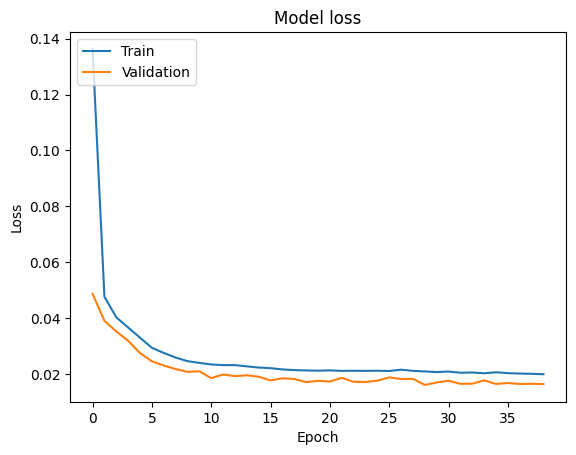

In [ ]:
history = model.history
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
model.save('my_model_10_features_best_20epochs_3layers_32batch_2056_1500_1024_50coerce.h5') 
model.summary()

c:\Users\playi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 100, 2056)         21464640  
                                                                 
 lstm_16 (LSTM)              (None, 100, 1500)         21342000  
                                                                 
 lstm_17 (LSTM)              (None, 1024)              10342400  
                                                                 
 repeat_vector_3 (RepeatVec  (None, 100, 1024)         0         
 tor)                                                            
                                                                 
 lstm_18 (LSTM)              (None, 100, 1500)         15150000  
                                                                 
 lstm_19 (LSTM)              (None, 100, 2056)         29252768  
                                                      

In [98]:
from keras.models import load_model
model = load_model('my_model_270_features_good_20epochs_moreparams')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 498, 512)          1603584   
                                                                 
 lstm_57 (LSTM)              (None, 498, 256)          787456    
                                                                 
 lstm_58 (LSTM)              (None, 128)               197120    
                                                                 
 repeat_vector_18 (RepeatVe  (None, 498, 128)          0         
 ctor)                                                           
                                                                 
 lstm_59 (LSTM)              (None, 498, 256)          394240    
                                                                 
 lstm_60 (LSTM)              (None, 498, 512)          1574912   
                                                      

1/1 [==============================] - 2s 2s/step


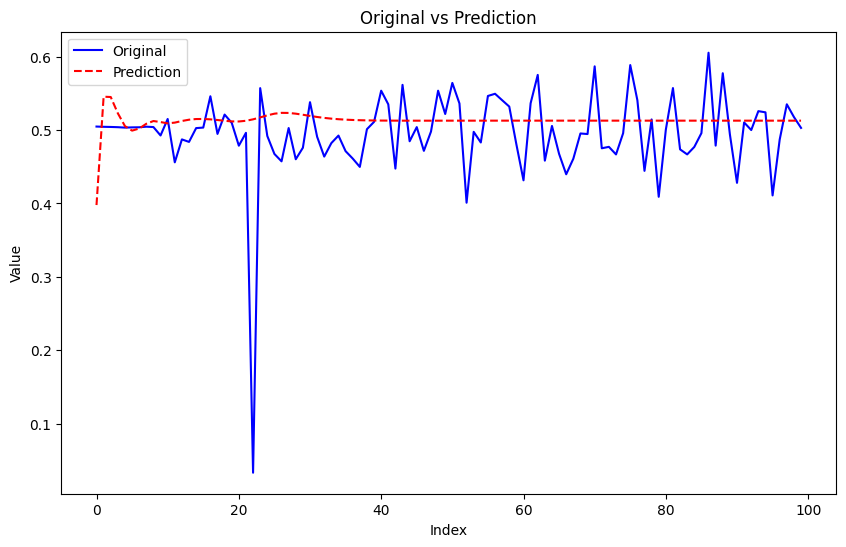

In [64]:
def plot_original_vs_prediction(original, prediction):
    """
    This function plots two numpy arrays: original and prediction on the same graph.

    Parameters:
    - original: numpy array, the original data.
    - prediction: numpy array, the predicted data.

    The function does not return anything but plots the original data and the prediction.
    """
    # Check if both arrays have the same length
    if len(original) != len(prediction):
        raise ValueError("The original and prediction arrays must have the same length.")
    
    # Generate a range for the x-axis based on the length of the arrays
    x_axis = np.arange(len(original))
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x_axis, original, label='Original', color='blue')
    plt.plot(x_axis, prediction, label='Prediction', color='red', linestyle='--')
    plt.title('Original vs Prediction')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

feature_number = 553
original = pd.read_hdf(NORMAL_FILES_PROC[1]).to_numpy()[:,:feature_number]
original = original.reshape(1,100,feature_number)
prediction = model.predict(original)
prediction = prediction.reshape(100,feature_number)
original = original.reshape(100,feature_number)


feature_to_plot = 78
plot_original_vs_prediction(original[:,feature_to_plot], prediction[:,feature_to_plot])




1/1 [==============================] - 2s 2s/step
the mae for file ../data/donnees_norm_proc/Scenario_id_001330.h5 is 0.015219757730733394
1/1 [==============================] - 2s 2s/step
the mae for file ../data/donnees_norm_proc/Scenario_id_001331.h5 is 0.017291188924269223
1/1 [==============================] - 2s 2s/step
the mae for file ../data/donnees_norm_proc/Scenario_id_001333.h5 is 0.018754775634308347
1/1 [==============================] - 2s 2s/step
the mae for file ../data/donnees_norm_proc/Scenario_id_001334.h5 is 0.017905518882507167
1/1 [==============================] - 2s 2s/step
the mae for file ../data/donnees_norm_proc/Scenario_id_001335.h5 is 0.014844675038218418
1/1 [==============================] - 2s 2s/step
the mae for file ../data/donnees_norm_proc/Scenario_id_001336.h5 is 0.017351553711187677
1/1 [==============================] - 2s 2s/step
the mae for file ../data/donnees_norm_proc/Scenario_id_001337.h5 is 0.024414679124074315
1/1 [======================

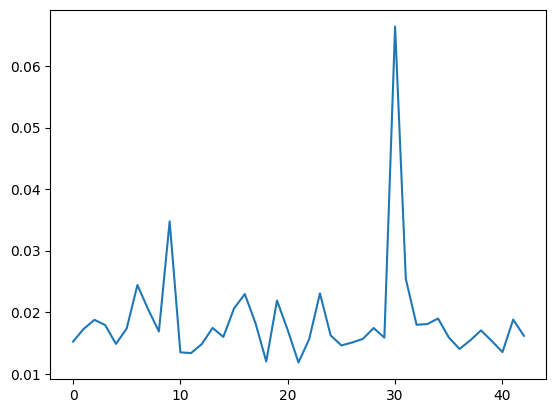

In [67]:
# plot the mae of all files in NORMAL_FILES_PROC
mae = []
for file in NORMAL_FILES_PROC[50:]:
    original = pd.read_hdf(file).to_numpy()[:,:feature_number]
    original = original.reshape(1,100,feature_number)
    prediction = model.predict(original)
    prediction = prediction.reshape(100,feature_number)
    original = original.reshape(100,feature_number)
    mae.append(mean_squared_error(original.flatten(), prediction.flatten()))
    print(f"the mae for file {file} is {mae[-1]}")
# plot histogram of mae and not graph
plt.plot(mae)



In [68]:
# Calculate the accuray of the model on all data using the threshold value
therehold = 0.03
correct_predictions = 0
all_predictions = 0
for file in NORMAL_FILES_PROC[:]:
    original = pd.read_hdf(file).to_numpy()[:,:feature_number]
    original = original.reshape(1,100,feature_number)
    prediction = model.predict(original)
    prediction = prediction.reshape(100,feature_number)
    err = mean_squared_error(original.flatten(), prediction.flatten())
    if (err < therehold):
        correct_predictions += 1
    all_predictions += 1

for file in ANORMAL_FILES_PROC[:]:
    original = pd.read_hdf(file).to_numpy()[:,:feature_number]
    original = original.reshape(1,100,feature_number)
    prediction = model.predict(original)
    prediction = prediction.reshape(100,feature_number)
    err = mean_squared_error(original.flatten(), prediction.flatten())
    if (err > therehold):
        correct_predictions += 1
    all_predictions += 1

print(f"the accuracy of the model is {correct_predictions/all_predictions*100}%")

1/1 [==============================] - 2s 2s/step
the accuracy of the model is 92.23300970873787%


TODO:

look at the four samples that look perfectly good and try to guess where the anomaly is (using the plot fonctions above)